# CESM-LE comparison
 - This example looks at total ecosystem C 1850-2014 
 - reading in ensemble of data from CESM1_LENS, CESM2_LENS, or CESM2-CMIP5 a relatively large dataset 
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu
 

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2020.12.0
dask.__version__

'2021.01.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300041',
                     walltime='3:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [7]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

Client Scheduler: tcp://10.12.205.19:35784 Dashboard: http://10.12.205.19/proxy/8787/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [8]:
def get_file(ee,model,field,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]

    if model == 'CESM2-CMIP5':
        topdir = '/glade/campaign/cesm/development/cross-wg/CESM2_CMIP5_forcings/' 
        mlist = sorted(glob.glob(topdir+'b.e21.BHIST.f09_g17.cesm2_cmip5_forcing*'))
        mm = mlist[ee]
        lnd    = '/lnd/proc/tseries/month_1/'
        ff     = glob.glob(mm+lnd+'*.h0.'+field+'.*')[0]
        
    if model == 'CESM2':
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
        mm = mlist[ee]
        lnd    = '/lnd/proc/tseries/month_1/'
        firstyear = 10*int(yr/10)
        yy    = '.'+str(firstyear)+'01-'+str(firstyear+9)+'12.'
        if yr>2009:
            yy = '.201001-201412.'
        ff     = glob.glob(mm+lnd+'*.h0.'+field+yy+'*')[0]
    return ff

In [9]:
#topdir = '/glade/campaign/cesm/development/cross-wg/CESM2_CMIP5_forcings/' 
#mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))

topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
mm = mlist
print(len(mm))        
        #nn      = lenskey[ee]topdir = '/glade/campaign/cesm/development/cross-wg/CESM2_CMIP5_forcings/' 
#mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
print(mm[:][-8:None])
    #mm = mlist[0]
#lnd    = '/lnd/proc/tseries/month_1/'
#ff     = glob.glob(mm+lnd+'*.h0.NBP*')[0]
#f

50
['/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1301.003', '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1301.004', '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1301.005', '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1301.006', '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1301.007', '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1301.008', '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1301.009', '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1301.010']


In [10]:
def all_files(model,field,firstyear,nens):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        files = [get_file(ee,'CESM1',field,0) for ee in range(nens)]
    if model == 'CESM2-CMIP5':
        files = [get_file(ee,'CESM2-CMIP5',field,0) for ee in range(nens)]
    if model =='CESM2':
        yrs = [*np.arange(firstyear,2009,10),2010]
        files = [[get_file(ee,'CESM2',field,yr) for yr in yrs] 
                 for ee in range(nens)]
    return files

In [11]:
def get_monthly(model,fields,firstyear,nens):
    first = True
    
    for field in fields:
        #find the appropriate files
        files = all_files(model,field,firstyear,nens)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2-CMIP5':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                ds = xr.open_mfdataset(files[0],combine='by_coords',parallel=True)
                tmp = xr.open_dataset(files[0][0])
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0])

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model])
        ds[field] = tmp[field]

    ds['landarea'] = ds['area']*ds['landfrac']
    ds['landarea'].name = 'landarea'
    ds['landarea'].attrs['units'] = 'km2'
        
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    ix = ds['time.year']>=firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [12]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [13]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### read in the data:
 - the less data you take, the faster this will run

In [14]:
%%time
#LENS1 starts in 1920, we'll do the same for LENS2

model = ['CESM1','CESM2-CMIP5','CESM2']
# always brackets, fields = ['GPP']
CESM1fields = ['GPP','NBP','NEP','NEE','TOTVEGC','DWT_PROD100C_GAIN','DWT_PROD10C_GAIN','WOOD_HARVESTC','DWT_CLOSS']  
CESM2fields = ['TOTVEGC','TWS']
var = ['TOTVEGC','TWS']
firstyear = 1850
nens = 50
#dsCESM1 = get_monthly(model[0],CESM1fields,firstyear,nens)#42
#dsCMIP5 = get_monthly(model[1],CESM2fields,firstyear,nens)#7
dsCESM2 = get_monthly(model[2],CESM2fields,firstyear,nens)#50+

CPU times: user 58 s, sys: 12.9 s, total: 1min 10s
Wall time: 1min 15s


### quick look at annual data

In [29]:
%%time
# Just mean value for each year, don't bother changing
for i in range(len(var)):
    ds[var[i]] = dsCESM2[var[i]].groupby('time.year').mean(skipna=True).compute()

CPU times: user 48.6 s, sys: 1min 44s, total: 2min 32s
Wall time: 4min 45s


In [30]:
# Dig into how data are actually being read in...
'''topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
mm = mlist
nens = (len(mm))        
# assumes first part of suffix = macro pert
# second part of suffix = micro pert
macro = np.empty(nens)
micro = np.empty(nens)
for i in range(nens):
    macro[i] = int(mm[i][-8:-4])
    micro[i] = int(mm[i][-3:None])

# identify a color for each macro pert
macro_unique = np.unique(macro)
macro_pert = len(macro_unique)
print(macro_unique)
colors = plt.cm.gist_ncar_r(np.linspace(0,1,macro_pert)) #pick colors
colors #print(colors[1])
# now replace macro id with integer (0,1,2,...)
macro_col = macro
for j in range(macro_pert):
    macro_col = np.where(macro_col == macro_unique[j], j, macro_col)
int(macro_col[0])'''


"topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'\nmlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))\nmm = mlist\nnens = (len(mm))        \n# assumes first part of suffix = macro pert\n# second part of suffix = micro pert\nmacro = np.empty(nens)\nmicro = np.empty(nens)\nfor i in range(nens):\n    macro[i] = int(mm[i][-8:-4])\n    micro[i] = int(mm[i][-3:None])\n\n# identify a color for each macro pert\nmacro_unique = np.unique(macro)\nmacro_pert = len(macro_unique)\nprint(macro_unique)\ncolors = plt.cm.gist_ncar_r(np.linspace(0,1,macro_pert)) #pick colors\ncolors #print(colors[1])\n# now replace macro id with integer (0,1,2,...)\nmacro_col = macro\nfor j in range(macro_pert):\n    macro_col = np.where(macro_col == macro_unique[j], j, macro_col)\nint(macro_col[0])"

In [16]:
# maybe just easier to assign values for each 'macro', even though first set isn't really the same initial conditions
col=['C4','C1','C2','C3','C0']
TileCol = np.repeat(col,10)
#TileCol

____________________________
### Look at TOTVEGC initial conditions 

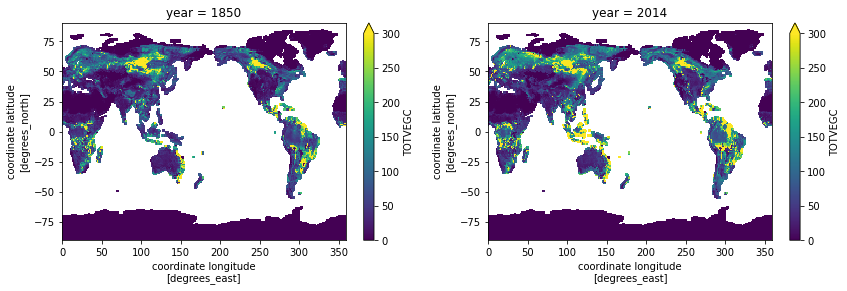

In [32]:
# Standard deveiation of VEGC in 1850
plt.figure(figsize=[14,4])
plt.subplot(121)
ds[var[0]].isel(year=0).std(dim='ens').plot(vmin=0,vmax=300);
plt.subplot(122)
ds[var[0]].isel(year=-1).std(dim='ens').plot(vmin=0,vmax=300);

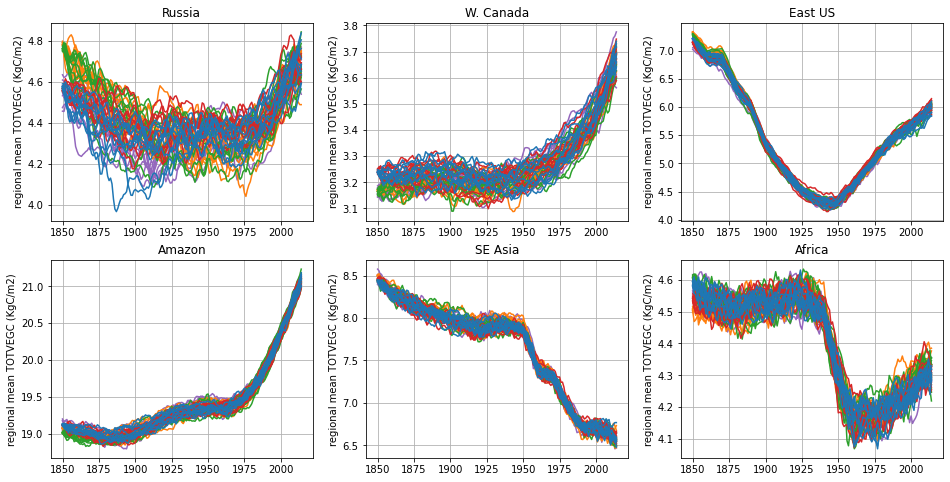

In [49]:
# Regional averages in TOTVEGC
n = len(temp.ens)
latS = [45, 45, 25, -5,10,-20] 
latN = [60, 60, 40,  5,30, 15] 
lonE = [80, 250,275,280,100,0]
lonW = [120,275,300,300,125,50]
region = ['Russia','W. Canada','East US','Amazon','SE Asia','Africa']
plt.figure(figsize=[16,8])
for h in range(len(latS)):
    temp = ds[var[0]].sel(lat=slice(latS[h],latN[h]), lon=slice(lonE[h],lonW[h])).mean(
        ['lat','lon'])#.sel(year=slice(1850,1900))
    plt.subplot(2,3,(h+1))
    plt.grid()
    plt.title(region[h])
    plt.ylabel('regional mean '+var[0]+' (KgC/m2)');
    for i in range(n):
        #macroID = int(macro_col[i])
        #plt.plot(temp.year,temp.isel(ens=i),color=colors[macroID]);
        plt.plot(temp.year,(temp*1e-3).isel(ens=i),color=TileCol[i]);
        

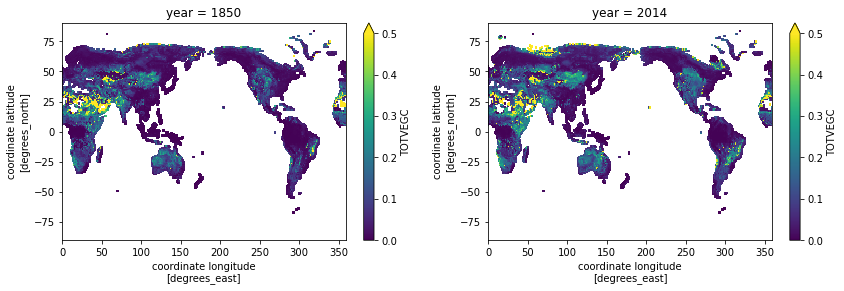

In [171]:
# CV of VEGC in 1850, 2014
plt.figure(figsize=[14,4])
plt.subplot(121)
(ds.isel(year=0).std(dim='ens')/ds.isel(year=0).mean(dim='ens')).plot(vmax=0.5,vmin=0);
plt.subplot(122)
(ds.isel(year=-1).std(dim='ens')/ds.isel(year=-1).mean(dim='ens')).plot(vmax=0.5,vmin=0);

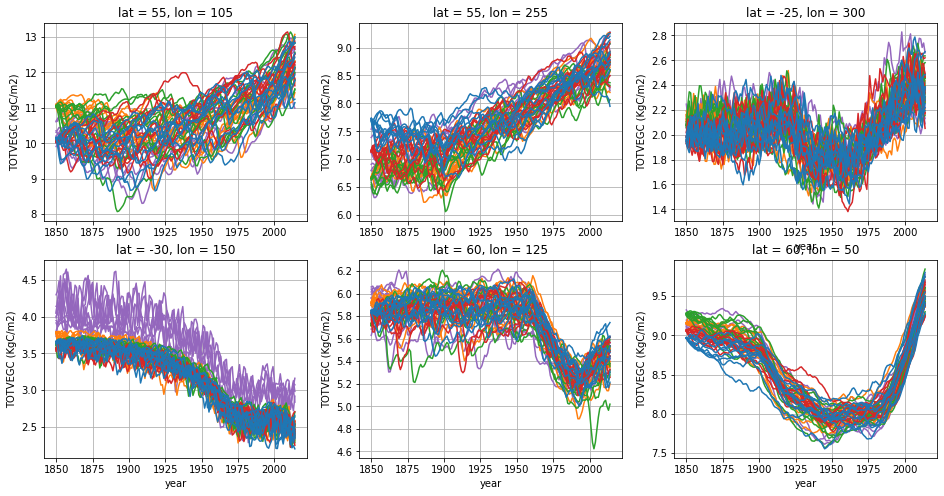

In [184]:
# As above, look at individual grid cells
n = len(temp.ens)
lats = [55, 55 ,-25,-30,60, 60]
lons = [105,255,300,150,125,50]

plt.figure(figsize=[16,8])
for h in range(len(lats)):
    temp = ds[var[0]].sel(lat=lats[h], lon=lons[h], method='nearest')
    plt.subplot(2,3,(h+1))
    plt.grid()
    plt.ylabel(CESM2fields[0]+' (KgC/m2)');
    plt.title('lat = '+str(lats[h])+', lon = '+str(lons[h]) )
    if h>=2: plt.xlabel('year')
    for i in range(n):
        #macroID = int(macro_col[i])
        #plt.plot(temp.year,temp.isel(ens=i),color=colors[macroID]);
        plt.plot(temp.year,(temp*1e-3).isel(ens=i),color=TileCol[i]);

____________________________
### Look at TWS initial conditions 

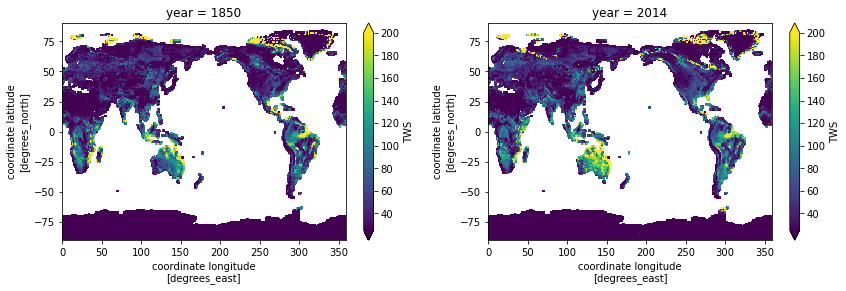

In [39]:
# Standard deveiation of TWS in 1850
plt.figure(figsize=[14,4])
plt.subplot(121)
ds[var[1]].isel(year=0).std(dim='ens').plot(vmin=25,vmax=200)
plt.subplot(122)
ds[var[1]].isel(year=-1).std(dim='ens').plot(vmin=25,vmax=200);

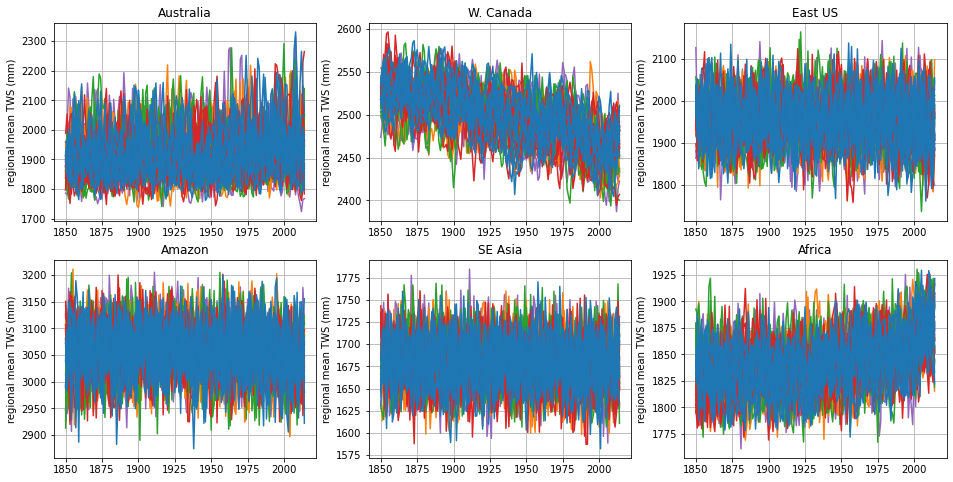

In [48]:
# Regional mean TWS
n = len(temp.ens)
latS = [-40, 45, 25, -5,10,-20] 
latN = [-10, 60, 40,  5,30, 15] 
lonE = [120, 250,275,280,100,0]
lonW = [144,275,300,300,125,50]
region = ['Australia','W. Canada','East US','Amazon','SE Asia','Africa']
plt.figure(figsize=[16,8])
for h in range(len(latS)):
    temp = ds[var[1]].sel(lat=slice(latS[h],latN[h]), lon=slice(lonE[h],lonW[h])).mean(['lat','lon'])
    plt.subplot(2,3,(h+1))
    plt.grid()
    plt.title(region[h])
    plt.ylabel('regional mean '+var[1]+' ('+dsCESM2[var[1]].attrs['units']+')');
    for i in range(n):
        plt.plot(temp.year,temp.isel(ens=i),color=TileCol[i]);
        

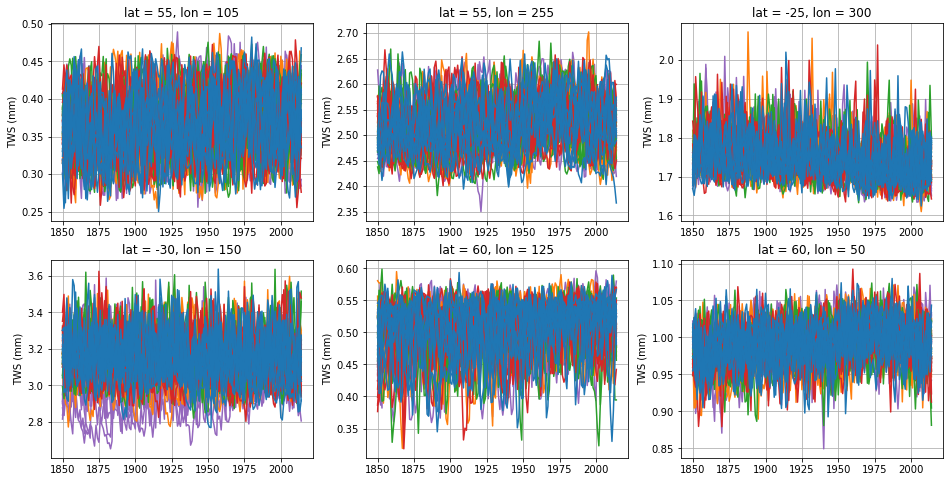

In [47]:
# as above, but for single points
n = len(temp.ens)
lats = [55, 55 ,-25,-30,60, 60]
lons = [105,255,300,150,125,50]

plt.figure(figsize=[16,8])
for h in range(len(lats)):
    temp = ds[var[1]].sel(lat=lats[h], lon=lons[h], method='nearest')
    plt.subplot(2,3,(h+1))
    plt.grid()
    plt.ylabel(var[1]+' ('+dsCESM2[var[1]].attrs['units']+')');
    plt.title('lat = '+str(lats[h])+', lon = '+str(lons[h]) )
    #if h>=2: plt.xlabel('year')
    for i in range(n):
        #macroID = int(macro_col[i])
        #plt.plot(temp.year,temp.isel(ens=i),color=colors[macroID]);
        plt.plot(temp.year,(temp*1e-3).isel(ens=i),color=TileCol[i]);